# Chest X-Ray Pneumonia Classifier

Pneumonia is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.

Pneumonia can range in seriousness from mild to life-threatening.

Pneumonia is usually caused by infection with viruses or bacteria and less commonly by other microorganisms, certain medications and conditions such as autoimmune diseases. Risk factors include other lung diseases such as cystic fibrosis, COPD, and asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke, or a weak immune system.

**Diagnosis** is often based on the symptoms and physical examination. *Chest X-ray*, blood tests, and culture of the sputum may help confirm the diagnosis. The disease may be classified by where it was acquired with community, hospital, or health care associated pneumonia.

In this notebook we will be utilizing https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/home dataset to help build an **Image Classification** model to classify Pneumonia from Chest X-Ray images 

From previous work on Medical Imagery, I have noticed DenseNet Architecture to generally perform better then pre-trained ResNet Models.

Thus we will experiment both with a Pre-Trained ResNet Model & DenseNet model. 

Given the nature of this dataset (Only 8 images for validation) we may later tweak the distribution of [train, valid, test] to contain more for our model to validate on. 

This will result an a more accurate representation of our models ability to **generalize** and not cause **over-fitting** of the training data

## Installing Kaggle, Importing Libraries, Downloading Data
Since we have Kaggle setup in our system, we will just comment a few lines out

In [ ]:
# !pip install kaggle --upgrade
# !pip install fastai

In [1]:
# importing
from fastai import *
from fastai.vision import *
import torch
from torchvision.models import *

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import os

/opt/conda/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Checking if GPU acceleration is enabled
torch.backends.cudnn.enabled == True

True

In [3]:
!pwd

/notebooks/course-v3/nbs/dl1


In [ ]:
# # configuring kaggle
# !mkdir .kaggle 

# cred = json.dumps({"username":"USERNAME","key":"KEY"}) 
# with open('.kaggle/kaggle.json', 'w') as f:
#     f.write(cred)

# # Configuring the file - we will run this twice (second time next block)
# !cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
# !kaggle config set -n path -v{/notebooks/course-v3/nbs/dl1}

In [ ]:
# # run for second time
# !cp .kaggle/kaggle.json ~/.kaggle/kaggle.json
# !kaggle config set -n path -v{/notebooks/course-v3/nbs/dl1}

In [ ]:
# # making private
# !chmod 600 /root/.kaggle/kaggle.json

In [4]:
# Making directories
!mkdir pneumonia_data

In [34]:
# Setting path to download data
path = '/notebooks/course-v3/nbs/dl1/pneumonia_data/'

In [10]:
# Downloading our data
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p {path}

100%|█████████████████████████████████████▉| 1.15G/1.15G [00:21<00:00, 82.4MB/s]
100%|██████████████████████████████████████| 1.15G/1.15G [00:21<00:00, 57.0MB/s]
unzip:  cannot find or open /notebooks/course-v3/nbs/dl1/pneumonia_data//chest_xray.zip, /notebooks/course-v3/nbs/dl1/pneumonia_data//chest_xray.zip.zip or /notebooks/course-v3/nbs/dl1/pneumonia_data//chest_xray.zip.ZIP.


In [12]:
# unzipping & removing zipped filed
!unzip -q -n {path}/chest-xray-pneumonia.zip -d {path}
!rm -rf {path}/chest-xray-pneumonia.zip

!unzip -q -n {path}/chest_xray.zip -d {path}
!rm -rf {path}/chest_xray.zip

In [35]:
path = f'{path}/chest_xray'

In [37]:
# Renaming our file to valid
!mv {path}/val {path}/valid
os.listdir(path)

['test', 'valid', 'train']

In [38]:
# Converting into FastAI Path object 
path = Path(path)

In [39]:
path.ls()

[PosixPath('/notebooks/course-v3/nbs/dl1/pneumonia_data/chest_xray/test'),
 PosixPath('/notebooks/course-v3/nbs/dl1/pneumonia_data/chest_xray/valid'),
 PosixPath('/notebooks/course-v3/nbs/dl1/pneumonia_data/chest_xray/train')]

## Creating Dataset 
We will be utilizing **FastAIs v1.0** framework for both formatting our data into a **DataBunch** object and building an image classifier

In [69]:
tfms_ = get_transforms(do_flip=True, flip_vert=False, max_rotate=0., max_zoom=0.02,
                      max_lighting=0.01, max_warp=0.)

In [70]:
src = (ImageItemList.from_folder(path)
                    .split_by_folder()
                    .label_from_folder())

def get_data(batch_size, image_size):
    data = (src.transform(tfms=tfms_, size=image_size)
               .databunch(num_workers=2,bs=batch_size).normalize(imagenet_stats))
    return data

In [81]:
# Our first DataBunch Object
data = get_data(32, 224)

In [82]:
data.classes

['NORMAL', 'PNEUMONIA']

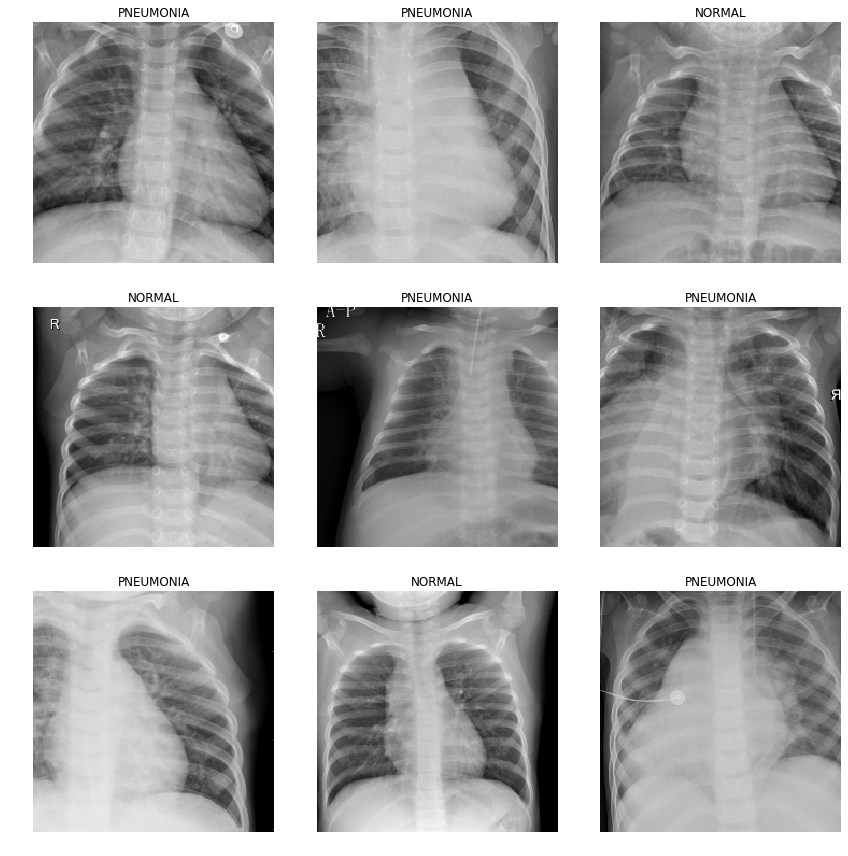

In [83]:
# Let's examine some of our data
data.show_batch(rows=3)

## Building our Model
We will experiment with both: **ResNet50** and **DenseNet169** using standard parameters (default for FastAI)

### ResNet50 (Pre-Trained)
A few disadvantages I have seen with medical images and a pre-trained ResNet when it comes to medical imagery is that distribution of data. Typically, this ResNet Pre-Trained Architecture has been trained on ImageNet, thus it's weights are biased more towards that type of data.

Another problem comes with the fact that these images are of one color channel. A Pre-Trained ResNet is usually trained on 3-Channels (RBG) 

In [84]:
# Arch
arch_resnet = models.resnet50

In [90]:
# Creating learning 
learn = create_cnn(data, arch_resnet, metrics=[error_rate, accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


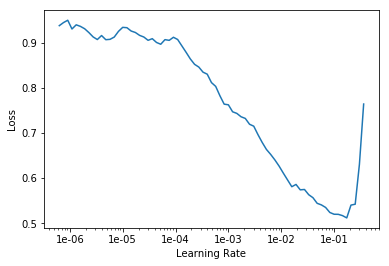

In [86]:
# Finding optimal learning rate
learn.lr_find()
learn.recorder.plot()

In [91]:
# lr = 7e-3
lr = 1e-2

In [92]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.195164,1.542861,0.437500,0.562500
2,0.135326,0.377852,0.187500,0.812500
3,0.089183,0.333807,0.125000,0.875000
4,0.049727,0.356492,0.125000,0.875000
5,0.038023,0.176838,0.062500,0.937500


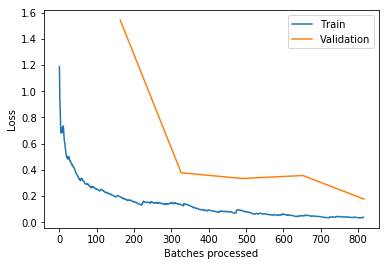

In [94]:
learn.recorder.plot_losses()

#### ResNet Conclusion
At epoch 3 & 4 we seem to have been *stuck* with and error rate of **0.125**, I believe this could have been because we we're stuck at a local mimima 

### DenseNet169
Now I hypothesis this will perform much better than a ResNet

In [96]:
arch_densenet = densenet169

In [110]:
learn = create_cnn(data, arch_densenet, metrics=[error_rate, accuracy])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


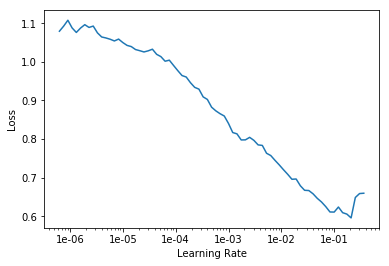

In [98]:
learn.lr_find()
learn.recorder.plot()

In [111]:
# lr = 1e-2
lr = 3e-2

In [112]:
# BEAT - .937
learn.fit_one_cycle(3, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy
1,0.206175,1.067490,0.187500,0.812500
2,0.086197,0.001685,0.000000,1.000000
3,0.035457,0.019169,0.000000,1.000000


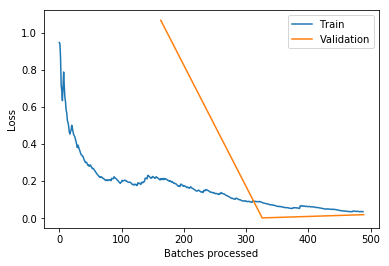

In [113]:
learn.recorder.plot_losses()

## Conclusion 
From testing both Architecture's my hypothesis holds. **DenseNet** seems to have performed much better on this problem. 

Though the **100%** accuracy, it's important to know the nature of this dataset may be at fault for this high accuracy. That is not to say this isn't a good model, but it is to say that it's not perfect. 

Ideally, you will want a larger Validation/Test set, which in our case it is validation (predicting) on **16 images**

Thus if tested on a much larger validation loss, this accuracy would be much more 'accurate' relative to inference. 

Thus, next steps would be to format the data in such a way:
* 80/20 [test/valid] split
* Fine-tuning DenseNet
* Testing with a seperate test directory (images it has never seen before)

Before going into production, I would also make sure that the Images at inference match the same type (augmentation & more) as what it was trained with 